<a href="https://colab.research.google.com/github/lblabucsd/Zada_Schulze_24/blob/main/behavior_analysis_pipeline_clear_wall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

latest update: mlb, Aug 19 2023


# Prep

In [ ]:
# Mount the Google Drive to the Google Colab notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from google.colab import auth
auth.authenticate_user()

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Zada_Schulze_paper/Colab_notebooks_paper'
%run data_processing_utils.ipynb

/content/drive/MyDrive/Zada_Schulze_paper/Colab_notebooks_paper


In [ ]:
# directories for the data and analysis
experiment_class = 'Clear_Wall'
tab_name = 'clearwall'


path = '/content/drive/MyDrive/Zada_Schulze_paper/Analysis_output/'+experiment_class+'/'
gsheet = 'https://docs.google.com/spreadsheets/d/1ud4Ifs4Sw3Kth9x_74JBBqgY0MvTXCbLroHDKO8mvQI/edit#gid=1453995064'

metadata = read_metadata(gsheet,tab_name)
experiments = metadata.index


figure_savepath = '/content/drive/MyDrive/Zada_Schulze_paper/Figures_output/Clear_Wall/'

sleap_nodes_jy = ['le','re','fb','mb','rb','t1','t2','t3','tt']
sleap_nodes_dz = ['le','re','by','t1','t2','tt']

sleap_nodes = sleap_nodes_jy

,experiment,exp_type,rig_ver,age,fish_num,fps_Hz,rig_mm,vid_px,trim,wall_pos_px,notes,tracking,habx,video,raw_vid_name
0,jy230614_c0,ZB,water-tight,2m,2,120,300,930,,468 3 492 999 496 999 472 3,shoal,good,3,5,jy_20230614_c0
1,jy230614_c1,ZB,water-tight,2m,2,120,300,930,,468 3 492 999 496 999 472 3,shoal,good,3,5,jy_20230614_c1
2,jy230614_c2,ZB,water-tight,2m,2,120,300,930,,468 3 492 999 496 999 472 3,shoal,good,3,5,jy_20230614_c2
3,jy230614_c3,ZB,water-tight,2m,2,120,300,930,,468 3 492 999 496 999 472 3,shoal,good,3,5,jy_20230614_c3
4,jy230614_c4,ZB,water-tight,2m,2,120,300,930,,468 3 492 999 496 999 472 3,shoal-ish,good,3,5,jy_20230614_c4
5,jy230614_c5,ZB,water-tight,2m,2,120,300,930,,468 3 492 999 496 999 472 3,shoal-ish,good,3,5,jy_20230614_c5
6,jy230614_c6,ZB,water-tight,2m,4,120,300,930,,468 3 492 999 496 999 472 3,shoal,"kinda tricky to proofread, some messed up iden...",3,5,jy_20230614_c6
7,jy230614_c7,ZB,water-tight,2m,4,120,300,930,,468 3 492 999 496 999 472 3,shoal,good,3,5,jy_20230614_c7
8,jy230614_c8,ZB,water-tight,2m,4,120,300,930,,468 3 492 999 496 999 472 3,shoal,acceptable,3,5,jy_20230614_c8
9,jy230614_c9,ZB,water-tight,2m,4,120,300,930,,468 3 492 999 496 999 472 3,shoal-ish,good enough,3,5,jy_20230614_c9


In [ ]:
# clear wall specific processing
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy
import scipy.stats as stats
sns.set(font_scale=3)
sns.set_style("white")



def get_wall_pos(wall_pos):
  """This script uses the xy pos of 4 corners in video to define the line the wall lies.
  """
  wall_pts_x = [float(xy) for xy in wall_pos.split()[::2]]
  wall_pts_y = [float(xy) for xy in wall_pos.split()[1::2]]

  # get the equation of the wall's midline
  x1 = (wall_pts_x[0]+wall_pts_x[3])/2
  y1 = (wall_pts_y[0]+wall_pts_y[3])/2
  x2 = (wall_pts_x[1]+wall_pts_x[2])/2
  y2 = (wall_pts_y[1]+wall_pts_y[2])/2
  slope = (y2 - y1) / (x2 - x1)
  y_intercept = y1 - slope * x1
  print(f"The equation of the wall is y = {slope:.2f}x + {y_intercept:.2f}")

  return wall_pts_x, wall_pts_y, x1, x2, y1, y2, slope, y_intercept

def fish_dist_to_wall(fish_x, fish_y,slope, y_intercept):
  """This script return the distance of fish (positive on right, negative on left) to the wall.
  """
  numerator = np.abs(fish_y - (slope * fish_x + np.full(fish_y.shape,y_intercept)))
  denominator = math.sqrt(1 + slope ** 2)
  distance = numerator / denominator

  # add sign to the distance array
  x_on_line = (fish_y - np.full(fish_y.shape,y_intercept))/slope
  displacement = np.where(x_on_line > fish_x, distance, 0) + np.where(x_on_line < fish_x, distance*(-1), 0)

  return distance, displacement

# Main workflow

## Level 0

In [ ]:
#show example data
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors

# Open the video file

for exp,spec,colors,cm,frame_start in zip(['jy230622_c8_trim', 'jy230614_c2'],\
                  ['Dc', 'Zf'],\
                  [['navy', 'cornflowerblue'],['lightgreen', 'darkgreen']],\
                  ['Blues','Greens'],\
                  [8300,10000]):

  if os.path.isfile(path + exp + '/' + exp + '_lev0_basics.npz') == True:
    folder = path + exp + '/'

    data = np.load(folder + exp + '_lev0_basics.npz', allow_pickle=True)
    fish_num, scale, bodylength, fps = data['fish_num'], data['scale'], data['f_bodylength_mm'], data['fps']
    exp_type, f_x, f_y = data['exp_type'], data['f_x'], data['f_y']
    f_heading, f_speed = data['f_heading'], data['f_speed']*scale

    wall_pos = metadata.loc[exp,'wall_pos_px']
    wall_pts_x, wall_pts_y, x1, x2, y1, y2, slope, y_intercept = get_wall_pos(wall_pos)
    distance, displacement = fish_dist_to_wall(f_x, f_y,slope, y_intercept)
    xx = np.linspace(x1, x2, 10); yy = slope * xx + y_intercept

    plot_length = 6*fps

    plt.figure(figsize=[3,3])
    fig, ax = plt.subplots()

    plt.plot(xx-3,yy,color='0.7',linewidth=5.0, alpha=0.5) # divider

    for f in range(fish_num):

        x = f_x[f][frame_start:frame_start+plot_length]
        y = f_y[f][frame_start:frame_start+plot_length]
        time = np.array(range(plot_length))

        norm = mcolors.Normalize(time.min(), time.max())
        cmap = plt.get_cmap(cm)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = mcoll.LineCollection(segments, array=time, cmap=cmap, norm=norm, linewidth=4, alpha=0.6)

        line = ax.add_collection(lc)

        plt.scatter(f_x[f][frame_start+plot_length],f_y[f][frame_start+plot_length],color=colors[f], alpha=0.9, s=30)
        dx = np.cos(np.deg2rad(f_heading[f][frame_start+plot_length]))
        dy = np.sin(np.deg2rad(f_heading[f][frame_start+plot_length]))
        #plt.arrow(f_x[f][frame_start+plot_length], f_y[f][frame_start+plot_length], dx, dy, shape='full', head_width=5, head_length=10, fc=colors[f], ec=colors[f])


    fig.colorbar(line, ax=ax)
    ax.set_xlim(410,550)
    ax.set_ylim(450,950)

    plt.title('swimming trajectories, 10s')
    #plt.savefig(figure_savepath +"_EXAMPLE_schooling_ClearWall_"+spec+".pdf", transparent=True)
    plt.show()

    plot_length = 30*fps
    plt.figure(figsize=[4,2])
    plt.plot(f_heading[0][frame_start:frame_start+plot_length], color=colors[0], linewidth=2.0, alpha=0.8)
    plt.plot(f_heading[1][frame_start:frame_start+plot_length], color=colors[1], linewidth=2.0, alpha=0.8)
    plt.title('heading angles, 30s')
    #plt.savefig(figure_savepath +"_EXAMPLE_heading_ClearWall_"+spec+".pdf", transparent=True)
    plt.show()


The equation of the wall is y = 64.00x + -30684.00


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

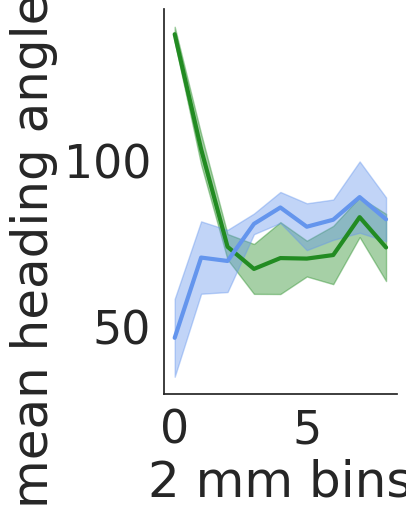

In [ ]:
#PLOT distance x alignment

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

Zf=[]; Dc=[];
summary_data = [Zf,Dc]
conditions = ['ZB','DC']

for exp in experiments:
  if os.path.isfile(path + exp + '/' + exp + '_lev0_basics.npz') == True and exp != "jy230614_c20": #exclude for tracking errors/NaNs

    # access analysis folder with npz and get the info
    folder = path + exp + '/'

    data = np.load(folder + exp + '_lev0_basics.npz', allow_pickle=True)
    fish_num, scale, bodylength = data['fish_num'], data['scale'], data['f_bodylength_mm']
    exp_type, f_x, f_y = data['exp_type'], data['f_x'], data['f_y']
    f_heading, f_speed = data['f_heading'], data['f_speed']*scale

    data = np.load(folder + exp + '_lev0_neighbor_stats.npz')
    f_closest_dist,f_closest_align = data['f_closest_dist']*scale,data['f_closest_align']

    for a,s in zip(conditions,summary_data):
      if exp_type==a and fish_num==2 and np.mean(f_closest_dist[0][0])<25:
        space_bins=[]
        for i in range(2,20,2):
          tmp=[]
          for ndx,(d,ang,sp1,sp2,y1,y2) in enumerate(zip(f_closest_dist[0][0], f_closest_align[0][0], f_speed[0], f_speed[1], f_y[0], f_y[1])):
            if i<d<i+2:
              if sp1>40 and sp2>40 and 900>y1>100 and 900>y2>100:
                tmp.append(abs(ang))
          space_bins.append(np.nanmean(tmp))
        s.append(space_bins)
        #print(exp, exp_type, space_bins)

plt.figure(figsize=[3,5])
for i,c in zip(summary_data,['forestgreen','cornflowerblue']):
  #for x in i:
  #  plt.plot(x, color=c, linewidth=1, alpha=0.4)
  plt.plot(np.nanmean(i,axis=0), color=c, linewidth=3)
  plt.fill_between(np.arange(np.nanmean(i,axis=0).shape[0]),
          np.nanmean(i, axis=0)+scipy.stats.sem(i, axis= 0),
          np.nanmean(i, axis=0)-scipy.stats.sem(i, axis=0), color=c, alpha=0.4)
plt.xlabel('2 mm bins')
plt.ylabel('mean heading angle diff')
sns.despine()
plt.savefig(figure_savepath +"_angle-by-heading.pdf", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()


heading angle diff


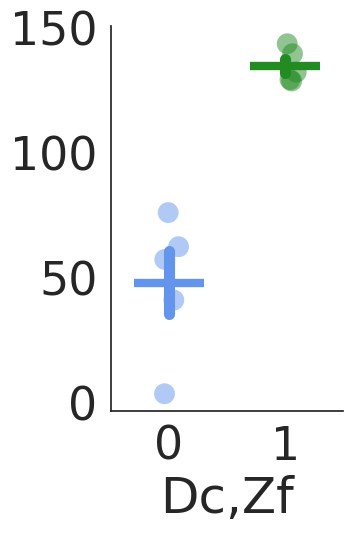

statistics for comparison: Mann-Whitney U test
U-statistic:  0.0 P-value:  0.007936507936507936
group #, N, MEANS, and SEM
0 5 47.93210381184849 12.449678969969284
normality test is ShapiroResult(statistic=0.9164129495620728, pvalue=0.5070687532424927)
1 5 134.47805015824682 2.9576425188359456
normality test is ShapiroResult(statistic=0.8783330321311951, pvalue=0.30182528495788574)
speed


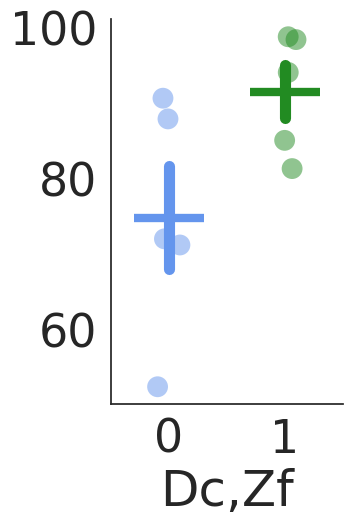

statistics for comparison: Mann-Whitney U test
U-statistic:  4.0 P-value:  0.09523809523809523
group #, N, MEANS, and SEM
0 5 74.79625201269275 6.866076469738793
normality test is ShapiroResult(statistic=0.9176381826400757, pvalue=0.5148195624351501)
1 5 91.47366140814806 3.5500513465508265
normality test is ShapiroResult(statistic=0.8711370229721069, pvalue=0.2710583209991455)
mean angular speed


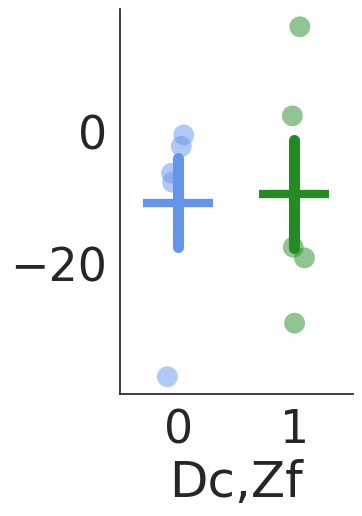

statistics for comparison: Mann-Whitney U test
U-statistic:  12.0 P-value:  1.0
group #, N, MEANS, and SEM
0 5 -10.813277969383819 6.689136592941517
normality test is ShapiroResult(statistic=0.7287440896034241, pvalue=0.018690668046474457)
1 5 -9.529173501518388 8.097347798226881
normality test is ShapiroResult(statistic=0.9275942444801331, pvalue=0.5800591707229614)


In [ ]:
#Get stats data for close (<5mm)

#angle diff
plt.figure(figsize=[3,5])

Zf=[]; Dc=[];
summary_data = [Dc,Zf]
conditions = ['DC','ZB']

for exp in experiments:
  if os.path.isfile(path + exp + '/' + exp + '_lev0_basics.npz') == True and exp != "jy230614_c20": #exclude for tracking errors/NaNs

    # access analysis folder with npz and get the info
    folder = path + exp + '/'

    data = np.load(folder + exp + '_lev0_basics.npz', allow_pickle=True)
    fish_num, scale, bodylength = data['fish_num'], data['scale'], data['f_bodylength_mm']
    exp_type, f_x, f_y = data['exp_type'], data['f_x'], data['f_y']
    f_heading, f_speed, f_ang_speed = data['f_heading'], data['f_speed']*scale, data['f_ang_speed']

    data = np.load(folder + exp + '_lev0_neighbor_stats.npz')
    f_closest_dist,f_closest_align = data['f_closest_dist']*scale,data['f_closest_align']

    for a,s in zip(conditions,summary_data):
      if exp_type==a and fish_num==2 and np.mean(f_closest_dist[0][0])<25:
        tmp = [abs(ang) for d,ang,y1,y2 in zip(f_closest_dist[0][0], f_closest_align[0][0], f_y[0], f_y[1]) if d<4 and 900>y1>100 and 900>y2>100]
        s.append(np.nanmean(tmp))

sns.pointplot(data=summary_data, estimator='mean', errorbar='se', markers='_', markersize=50, linewidth=8, palette=['cornflowerblue','forestgreen'], linestyle='none')
sns.stripplot(data=summary_data, s=15, palette=['cornflowerblue','forestgreen'], jitter=True, alpha=0.5)

plt.xlabel('Dc,Zf')
print('heading angle diff')
sns.despine()
plt.savefig(figure_savepath +"_heading_angle_difference.pdf", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

print('statistics for comparison: Mann-Whitney U test')
data = pd.DataFrame({
    'value': np.concatenate(summary_data),
    'group': np.repeat(conditions,
                       repeats=[len(summary_data[0]), len(summary_data[1])])
})

# Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(Dc,Zf)
print("U-statistic: ", u_statistic, "P-value: ", p_value)

print("group #, N, MEANS, and SEM")
for ndx,i in enumerate(summary_data):
  print(ndx, len(i), np.mean(i), scipy.stats.sem(i))
  print('normality test is', scipy.stats.shapiro(i))




#speed
plt.figure(figsize=[3,5])

Zf=[]; Dc=[];
summary_data = [Dc,Zf]
conditions = ['DC','ZB']

for exp in experiments:
  if os.path.isfile(path + exp + '/' + exp + '_lev0_basics.npz') == True and exp != "jy230614_c20":

    # access analysis folder with npz and get the info
    folder = path + exp + '/'

    data = np.load(folder + exp + '_lev0_basics.npz', allow_pickle=True)
    fish_num, scale, bodylength = data['fish_num'], data['scale'], data['f_bodylength_mm']
    exp_type, f_x, f_y = data['exp_type'], data['f_x'], data['f_y']
    f_heading, f_speed, f_ang_speed = data['f_heading'], data['f_speed']*scale, data['f_ang_speed']

    data = np.load(folder + exp + '_lev0_neighbor_stats.npz')
    f_closest_dist,f_closest_align = data['f_closest_dist']*scale,data['f_closest_align']

    for a,s in zip(conditions,summary_data):
      if exp_type==a and fish_num==2 and np.mean(f_closest_dist[0][0])<25:
        tmp = [np.mean([sp1,sp2]) for d,sp1,sp2,y1,y2 in zip(f_closest_dist[0][0], f_speed[0], f_speed[1], f_y[0], f_y[1]) if d<4 and 900>y1>100 and 900>y2>100]
        s.append(np.nanmean(tmp))

sns.pointplot(data=summary_data, estimator='mean', errorbar='se', markers='_', markersize=50, linewidth=8, palette=['cornflowerblue','forestgreen'], linestyle='none')
sns.stripplot(data=summary_data, s=15, palette=['cornflowerblue','forestgreen'], jitter=True, alpha=0.5)

plt.xlabel('Dc,Zf')
print('speed')
sns.despine()
plt.savefig(figure_savepath +"_mean_speed.pdf", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

print('statistics for comparison: Mann-Whitney U test')
data = pd.DataFrame({
    'value': np.concatenate(summary_data),
    'group': np.repeat(conditions,
                       repeats=[len(summary_data[0]), len(summary_data[1])])
})

# Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(Dc,Zf)
print("U-statistic: ", u_statistic, "P-value: ", p_value)

print("group #, N, MEANS, and SEM")
for ndx,i in enumerate(summary_data):
  print(ndx, len(i), np.mean(i), scipy.stats.sem(i))
  print('normality test is', scipy.stats.shapiro(i))



#angular speed
plt.figure(figsize=[3,5])

Zf=[]; Dc=[];
summary_data = [Dc,Zf]
conditions = ['DC','ZB']

for exp in experiments:
  if os.path.isfile(path + exp + '/' + exp + '_lev0_basics.npz') == True and exp != "jy230614_c20":

    # access analysis folder with npz and get the info
    folder = path + exp + '/'

    data = np.load(folder + exp + '_lev0_basics.npz', allow_pickle=True)
    fish_num, scale, bodylength = data['fish_num'], data['scale'], data['f_bodylength_mm']
    exp_type, f_x, f_y = data['exp_type'], data['f_x'], data['f_y']
    f_heading, f_speed, f_ang_speed = data['f_heading'], data['f_speed']*scale, data['f_ang_speed']

    data = np.load(folder + exp + '_lev0_neighbor_stats.npz')
    f_closest_dist,f_closest_align = data['f_closest_dist']*scale,data['f_closest_align']

    for a,s in zip(conditions,summary_data):
      if exp_type==a and fish_num==2 and np.mean(f_closest_dist[0][0])<25:
        tmp = [np.mean([sp1,sp2]) for d,sp1,sp2,y1,y2 in zip(f_closest_dist[0][0], f_ang_speed[0],f_ang_speed[1], f_y[0], f_y[1]) if d<4 and 900>y1>100 and 900>y2>100]
        s.append(np.nanmean(tmp))

sns.pointplot(data=summary_data, estimator='mean', errorbar='se', markers='_', markersize=50, linewidth=8, palette=['cornflowerblue','forestgreen'], linestyle='none')
sns.stripplot(data=summary_data, s=15, palette=['cornflowerblue','forestgreen'], jitter=True, alpha=0.5)

plt.xlabel('Dc,Zf')
print('mean angular speed')
sns.despine()
plt.savefig(figure_savepath +"_mean_ang_speed.pdf", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

print('statistics for comparison: Mann-Whitney U test')
data = pd.DataFrame({
    'value': np.concatenate(summary_data),
    'group': np.repeat(conditions,
                       repeats=[len(summary_data[0]), len(summary_data[1])])
})

# Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(Dc,Zf)
print("U-statistic: ", u_statistic, "P-value: ", p_value)

print("group #, N, MEANS, and SEM")
for ndx,i in enumerate(summary_data):
  print(ndx, len(i), np.mean(i), scipy.stats.sem(i))
  print('normality test is', scipy.stats.shapiro(i))